# Data Curation
## Assignment 1 for HCDS 512, Autumn 2018

The purpose of this notebook is to complete an exercise in reproducible data curation. For this exercise, I acquired, processed, and analyzed data on English Wikipedia traffic from 2008 - current using two Wikimedia REST API's. The notebook is divided into the following sections:

 - Data Acquisition
     - Pagecount (Legacy Data)
     - Pageviews (New Data)
 - Data Processing
 - Analysis

In [ ]:
#Import necessary packages
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
import requests

## Data Acquisition

This section contains the code to acquire data from the two different Wikimedia REST API's. Since the parameters for the API calls to each API are slightly different, I chose to complete the calls in two different sections of code. For both, much of the code was taken from the examples detailed in this example workbook which is licensed CC0: http://paws-public.wmflabs.org/paws-public/User:Jtmorgan/data512_a1_example.ipynb

Before breaking out the code into sections for the legacy API and the current data API, I define a few things that will be used in both sections directly below. First, I define the headers that will be passed in the API call; this includes my github account for 'User-Agent' and my email account as the 'From' (i.e. to define who is making the API call). Next, I create a function 'api_call' which uses python's json package to make the API call, and turns the results of the call into a JSON variable that can then be saved or processed. The arguments to the function are simply the endpoint for the call and the parameters to be passed to the call. By setting up a function this way I don't have to repeat the same lines of code each time I make multiple API calls.

In [3]:
#Define headers
headers = {
    'User-Agent': 'https://github.com/kentdanas',
    'From': 'kdanas@uw.edu'
}

#Function to save data from API calls
def api_call(endpoint,params):
    call = requests.get(endpoint.format(**params), headers=headers)
    response = call.json()
    return response

### Pagecount (Legacy Data)

The first API calls I make are to the Pagecount API, which contains legacy Wikipedia traffic data, from December 2012 through July 2016. More information about this API can be found here: https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts. 

This API contains data for both the mobile site and the desktop site. For this analysis both were needed, so after defining the endpoint, I defined a list of access sites which I could loop through to make multiple API calls. Within the loop, for each access site, I define the name of the JSON file I am going to save (according to the instructions in the assignment), define the parameters to pass through (I pulled all data available at monthly granularity for each access site), and then make the API call using the function I defined above. Finally, I save the results to a JSON file; all resulting raw data files can be found in the data_raw folder of this GitHub repository.

In [5]:
#Define endpoint
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

#Define access points
access_sites = ['mobile-site', 'desktop-site']

#Make API call for each access point
for access_site in access_sites:
    
    #Define filename and parameters to pass to API call
    file_name = '../data_raw/pagecount_' + access_site + '_200801_201809.json'

    params_legacy = {"project" : "en.wikipedia.org",
                     "access-site" : access_site,
                     "granularity" : "monthly",
                     "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                     "end" : "2016070100"
                    }
    
    #Make API call
    monthly_pagecounts = api_call(endpoint_legacy, params_legacy)
    
    #Save raw data file
    with open(file_name, 'w') as f:
        json.dump(monthly_pagecounts, f)

### Pageviews (New Data)

In addition to the legacy pagecount data, for this project I also acquired data from the current Pageviews API, which contains data from July 2015 through last month (October 2018 at the time of this writing). More information about this API can be found here: https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews. 

The process for acquiring this data via API call is almost exactly the same as the process for acquiring the legacy data described in the section above, with a few minor differences:

 - In this case, the API contains data for three different access sites: desktop, mobile app, and mobile web. I pulled data for all three of these, running through the API call loop three times.
 - This new API differentiates between human (user) traffic and other traffic such as web crawlers or spiders. Since for this analysis I was only interested in user traffic, within the parameters I have specified "agent" as "user".
 - Since this API contains current data, the end date is the current month (October 2018 at the time of writing).

In [6]:
#Define endpoint
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

#Define access points
access_sites = ['mobile-app', 'desktop', 'mobile-web']

#Make API call for each access point
for access_site in access_sites:
    
    #Define filename and parameters to pass to API call
    file_name = '../data_raw/pageview_' + access_site + '_201507_201809.json'
    
    params_pageviews = {"project" : "en.wikipedia.org",
                        "access" : access_site,
                        "agent" : "user",
                        "granularity" : "monthly",
                        "start" : "2001010100",
                        # for end use 1st day of month following final month of data
                        "end" : '2018101000'
                        }
    
    #Make API call
    monthly_pageviews = api_call(endpoint_pageviews, params_pageviews)
    
    #Save raw data file
    with open(file_name, 'w') as f:
        json.dump(monthly_pageviews, f)

## Data Processing

After making all of the necessary API calls, the data needed to be read from the resulting JSON files into dataframes and processed. To do so, I used the json package 'json.load' function, and then converted the results to a dataframe using the Pandas 'DataFrame' function. Since there were five different files to do this for in this case, I did this in a for loop to avoid rewriting the same code. In order to do this, I created a dictionary to save each dataframe in within the loop. I also used the glob package to define the files to process; using this method tells the code to loop through each file in the specified folder that ends in .json. This way, the code would work exactly the same even if more files were added later (i.e. it doesn't work only for the 5 files used in this example).

At the end of the loop, before saving the dataframe to the dictionary, I rename the 'views' or 'count' column (depending on whether the data was from the legacy or current API) to be more descriptive to make later processing easier. I do this automatically by searching for the access site in the filename of the current file being processed.

Note: this process could have been done directly in the data acquisition steps above, rather than saving the JSON files and then later reading them in again to process them. However, I chose to do this in a separate step because both APIs limit the number of API calls that can be made per user to 200, and so it seemed useful to have all processing separate from the initial API call so that if the processing needed to be changed, the code could be rerun without making another API call.

In [10]:
#Create dictionary to save dataframes
views = {}

#Specify folder from which to read all json files
file_path = '../data_raw/*.json'
files = glob.glob(file_path)

for file in files:
    #open file
    with open(file, 'r') as f:
        data = json.load(f)
    
    #convert to dataframe
    df = pd.DataFrame(data['items'])
    
    #change views column name
    view_name = re.search(r'\\(.+?)_20', file).group(1) + '_views'
    if 'views' in df.columns:
        df.rename(columns={'views': view_name}, inplace=True)
    elif 'count' in df.columns:
        df.rename(columns={'count': view_name}, inplace=True)
    
    #save dataframe in data dictionary
    views[view_name] = df

In the step above, each JSON file was been read and converted to a dataframe, and all of the dataframes were saved in a data dictionary so that this could be done in one for loop over all files, rather than repeating the code many times. Now below I pull the dataframes out of the dictionary and merge them into one dataframe, joining them on the timestamp column, and using an outer join so that all dates are kept even if data does not exist for every access site.

In [11]:
#Merge all dataframes from the data dictionary
keys = list(views.keys())
combined_data = views[keys[0]]

for i in range(1, len(keys)):
    combined_data = combined_data.merge(views[keys[i]], how = 'outer', on = ['timestamp'])


After joining the data into one dataframe, I create some additional columns as needed for this analysis:
 - 'year': pulling the year out of the timestamp
 - 'month': pulling the month out of the timestamp
 - 'pageview_mobile_views': combining the mobile-app and mobile-web views into one mobile-view category
 - 'pagecount_all_views': combining mobile site and desktop site views for the pagecount data
 - 'pageview_all_views': same as above for the pageview data

In [13]:
#Create additional needed columns
combined_data['year'] = combined_data['timestamp'].str[0:4]
combined_data['month'] = combined_data['timestamp'].str[4:6]
combined_data['pageview_mobile_views'] = combined_data['pageview_mobile-app_views'] + combined_data['pageview_mobile-web_views']
combined_data['pagecount_all_views'] = combined_data['pagecount_mobile-site_views'] + combined_data['pagecount_desktop-site_views']
combined_data['pageview_all_views'] = combined_data['pageview_mobile_views'] + combined_data['pageview_desktop_views']

Next I select only the year, month, and views columns to keep in a final dataframe for analysis. I also rename several of the columns according to the assignment instructions.

In [14]:
#Keep only needed columns
combined_data = combined_data[['year',
                              'month',
                              'pagecount_all_views',
                              'pagecount_desktop-site_views', 
                              'pagecount_mobile-site_views',
                              'pageview_all_views',
                              'pageview_mobile_views', 
                              'pageview_desktop_views']]

#Rename columns as needed
combined_data.rename(columns={'pagecount_mobile-site_views':'pagecount_mobile_views'}, inplace=True)
combined_data.rename(columns={'pagecount_desktop-site_views':'pagecount_desktop_views'}, inplace=True)

As a final processing step, I fill all blanks in the dataset with zeros according to the assignment instructions. I also sort the data so it is in chronological order to make it easier to view manually, after it got shuffled in the merging process.

In [15]:
#Fill zeros
combined_data = combined_data.fillna(0)

#Sort
combined_data = combined_data.sort_values(['year', 'month'])

Finally, I save the final processed dataframe to a csv for record keeping; this file is saved in the 'data_clean' folder of this repository.

In [16]:
#Save CSV
combined_data.to_csv('../data_clean/en-wikipedia_traffic_200801-201709.csv', index = False)

## Analysis

Now that I have a final dataframe with processed data, I can proceed to an analysis. For this assignment, the analysis is simply creating a time series visualization of the data. In order to do so, first I make a few minor changes, including creating a new column of dates in a format that matplotlib will recognize (prior to this I only had 'yyyy' and 'mm' as text strings in the data), and replacing the zeros with nans so missing data does not show up on the plot.

In [17]:
#Change dates to format that matplotlib will recognize
dates = pd.to_datetime(combined_data['year'] + combined_data['month'], format='%Y%m')

#Replace zeros with 'nans' so the plot doesn't show them
combined_data.replace(0, float('nan'), inplace=True)

Finally, I make a scatterplot of all data using the matplotlib package. I plot the desktop, mobile, and total views for both the legacy API (dashed lines) and the current API (solid lines), converted to millions of views so the axis is easier to read. I then add axis labels, a title, and a legend. I also save the figure as a .png to the 'results' folder of this repository.

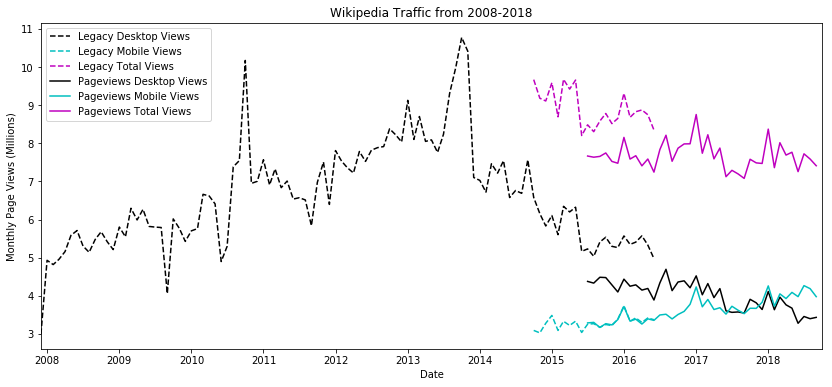

In [39]:
#Plot results and save figure as .png file
plt.figure(figsize=(14,6))
plt.plot(dates, combined_data['pagecount_desktop_views']/1e9, 'k--')
plt.plot(dates, combined_data['pagecount_mobile_views']/1e9, 'c--')
plt.plot(dates, combined_data['pagecount_all_views']/1e9, 'm--')
plt.plot(dates, combined_data['pageview_desktop_views']/1e9, 'k-')
plt.plot(dates, combined_data['pageview_mobile_views']/1e9, 'c-')
plt.plot(dates, combined_data['pageview_all_views']/1e9, 'm-')
plt.xlabel('Date')
plt.ylabel('Monthly Page Views (Millions)')
plt.title('Wikipedia Traffic from 2008-2018')
plt.xlim(('2007-12-01', '2018-10-01'))
plt.legend(['Legacy Desktop Views', 
            'Legacy Mobile Views', 
            'Legacy Total Views', 
            'Pageviews Desktop Views',
            'Pageviews Mobile Views',
            'Pageviews Total Views'])
plt.savefig('../results/wikipedia_traffic_2008-2018.png')
plt.show();

The plot shows that total Wikipedia traffic has increased since 2008-2009, but seems to have remained relatively flat in the 7-9 million views per month range for the last couple of years. Interestingly, during the few months of overlap between the legacy and current data, the legacy appears to have reported higher traffic for desktop views, but almost exactly the same traffic for mobile views (the blue line and dashed line are almost indistinguishable from mid-2015 - mid-2016). This is probably due to the fact that for the current API call I only requested 'user' data and not data from other 'agents', which may only be relevant for desktop views. Also of note, it appears that mobile traffic has been increasing recently, and as of mid-2018 appears to have surpassed desktop traffic, which has been slowly decreasing over the past 4 years.